In [19]:
from typing import List
from copy import deepcopy

import random
import collections

import h5py

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements
from qiskit.qasm2 import dumps
from qiskit_ibm_runtime import QiskitRuntimeService

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [20]:
ibm_computer: str = "ibm_fez"

service = QiskitRuntimeService(name="dalfaver@msu.edu")
backend = service.backend(ibm_computer)
sampler = Sampler(backend)

qiskit_runtime_service.__init__:WARNING:2026-02-05 10:45:36,686: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-05 10:45:36,690: Using instance: open-instance, plan: open


## Build a tiled pool

In [21]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 108]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819716
(change of -0.20417052920206835)
Current ansatz: [244, 74, 228, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531887
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734878)]
Initial energy: -6.327276154819716
Optimizing energy with indices [244, 74, 228, 108, 210]...
Starting point: [np.float64(0.785398175975639

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916438682456)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 57]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614608976
(change of -0.13682545978899352)
Current ansatz: [241, 79, 228, 210, 57]
Performing final convergence check...
Total gradient norm: 0.0003254105179039936

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615072614
(change of -0.1368254602526422)
Current ansatz: [241, 74, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013515787565729383

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001350560817700983

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0000000000000058)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 198]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617649
(change of -0.12310562561764016)
Current ansatz: [244, 79, 198]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199634004
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485071047536024)]
Initial energy: -6.123105625617649
Optimizing energy with indices [244, 79, 198, 228]...
Starting point: [np.float64(0.7853981603119451), np.float64(0.7853981603795771), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689596)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 198]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057733311
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916295077763)]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 228, 210, 108]...
Starting point: [np.float64(-0.785398162447052), np.float64(-0.7853981711958521), np.float64(0.16357028748210503), np.float64(0.16356997569593643), np.float64(0.0)]

Current energy: -6.464101615067952
(change of -0.13682546024798015)
Current ansatz: [241, 74, 228, 210, 108]
Performing final convergence check...
Total gradient norm: 0.00013840064821418684

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 57]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072774
(change of -0.13682546025278697)
Current ansatz: [244, 79, 228, 210, 57]
Performing final convergence check...
Total gradient norm: 0.000135056081442826

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0000000000000036)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 216]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763838)
Current ansatz: [241, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767302
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048167666)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 79, 216, 225]...
Starting point: [np.float64(-0.7853981624814353), np.float64(0.7853981626766198), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819948
(change of -0.2041705292023046)
Current ansatz: [241, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964115398415
Operator(s) added to ansatz: [54]
Gradients: [np.float64(-2.089491578871177)]
Initial energy: -6.327276154819948
Optimizing energy with indices [241, 79, 216, 225, 54]...
Starting point: [np.float64(-0.7853982205487021), np.float64(0.7853982043140048), np.float64(-0.16357029099862372), np.float64(-0.1635699889292778), np.float64(0.0)]

Current energy: -6.464101614739763
(change of -0.1368254599198151)
Current ansatz: [241, 79, 216, 225, 54]
Performing final convergence check...
Total gradient norm: 0.0003351091692272735

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964115398415 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 57]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819719
(change of -0.2041705292020799)
Current ansatz: [244, 79, 228, 57]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-1.9999999999969473)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 120]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.1231056253012826
(change of -0.12310562530309443)
Current ansatz: [225, 79, 120]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526204648539
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.485071048889239)]
Initial energy: -6.1231056253012826
Optimizing energy with indices [225, 79, 120, 156]...
Starting point: [np.float64(0.7854035417148227), np.float64(0.7854075559311637), np.float64(0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154483843
(change of -0.2041705291825604)
Current ansatz: [225, 79, 120, 156]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24095257780531
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0895005268730102)]
Initial energy: -6.327276154483843
Optimizing energy with indices [225, 79, 120, 156, 228]...
Starting point: [np.float64(0.7853942888658061), np.float64(0.7853897046603734), np.float64(0.16356756471343573), np.float64(0.16356936264078176), np.float64(0.0)]

Current energy: -6.464101614718532
(change of -0.13682546023468944)
Current ansatz: [225, 79, 120, 156, 228]
Performing final convergence check...
Total gradient norm: 0.0002944057752895776

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24095257780531 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775818
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682823)]
Initial energy: -6.1231056255624825
Optimizing energy with indices [228, 26, 228, 210]...
Starting point: [np.float64(-0.7853947065772612), np.float64(0.7853985308794263), np.float64(0.12248927961669973), np.float64(0.0)]

Current energy: -6.327276154765017
(change of -0.20417052920253465)
Current ansatz: [228, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069122
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438633278)]
Initial energy: -6.327276154765017
Optimizing energy with indices [228, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853947065771328), np.float64(0.7853982468601286), np.float64(0.16357028648716873), np.float64(0.16356997194353046), np.float64(0.0)]

Current energy: -6.4641016150180075
(change of -0.13682546025299036)
Current

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734934)]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134318
(change of -0.1368254603146104)
Current ansatz: [241, 79, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 198]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233836)
Current ansatz: [241, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964058377264
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089491628942171)]
Initial energy: -6.327276154819986
Optimizing energy with indices [241, 79, 225, 198, 120]...
Starting point: [np.float64(-0.7853981662933148), np.float64(0.7853981545803549), np.float64(-0.16357028752134434), np.float64(-0.16356997584374114), np.float64(0.0)]

Current energy: -6.464101615072514
(change of -0.1368254602525285)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013521654536773468

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964058377264 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089492926734876)]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 120]...
Starting point: [np.float64(0.7853981646904773), np.float64(0.7853981643651435), np.float64(0.16357019740836662), np.float64(-0.1635696366828739), np.float64(0.0)]

Current energy: -6.4641016151315025
(change of -0.13682546031180376)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916447538887)]
Initial energy: -6.32727615481998
Optimizing energy with indices [244, 26, 228, 210, 198]...
Starting point: [np.float64(0.785398156811469), np.float64(0.785398154431449), np.float64(0.16357028642350993), np.float64(0.16356997171157828), np.float64(0.0)]

Current energy: -6.46410161505858
(change of -0.1368254602386001)
Current ansatz: [24

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001435936303541698

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000027)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 225]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617631
(change of -0.12310562561761706)
Current ansatz: [244, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.48507104742827)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 147]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001351540793384578

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041893821 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0000000000000058)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 198]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617649
(change of -0.12310562561764016)
Current ansatz: [244, 79, 198]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199634004
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.4850710475360245)]
Initial energy: -6.123105625617649
Optimizing energy with indices [244, 79, 198, 141]...
Starting point: [np.float64(0.7853981603119451), np.float64(0.7853981603795771), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615061342
(change of -0.13682546024133835)
Current ansatz: [244, 79, 198, 141, 228]
Performing final convergence check...
Total gradient norm: 0.00014200521572705377

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964021189124 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477671423)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101614672586
(change of -0.13682545985261552)
Current ansatz: [244, 31, 225, 198, 210]
Performing final convergence check...
Total gradient norm: 0.00029671020679084166

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381052 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.00000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000027)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 225]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617631
(change of -0.12310562561761706)
Current ansatz: [244, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474282707)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 210]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.12248869758311001), np.float64(0.0)]

Current energy: -6.327276154816644
(change of -0.20417052920599765)
Current ansatz: [225, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056416012
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916407310458)]
Initial energy: -6.327276154816644
Optimizing energy with indices [225, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853984379184568), np.float64(0.7853991591701261), np.float64(0.16357028929940762), np.float64(0.16356997348722394), np.float64(0.0)]

Current energy: -6.46410161506949
(change of -0.1368254602528456)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.089492926734874)]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 135]...
Starting point: [np.float64(0.7853981646904773), np.float64(0.7853981643651435), np.float64(0.16357019740836662), np.float64(-0.1635696366828739), np.float64(0.0)]

Current energy: -6.4641016151326465
(change of -0.13682546031294773)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617638
(change of -0.12310562561762772)
Current ansatz: [241, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474288693)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 210]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819988
(change of -0.2041705292023499)
Current ansatz: [241, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138126
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643867201)]
Initial energy: -6.327276154819988
Optimizing energy with indices [241, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853981604483139), np.float64(0.7853981623217249), np.float64(0.16357028648498867), np.float64(0.16356997194327816), np.float64(0.0)]

Current energy: -6.464101615071929
(change of -0.13682546025194053)
Current ansatz: [241, 26, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013555110317705658

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138126 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819985
(change of -0.20417052920233836)
Current ansatz: [241, 74, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964043282357
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916421979004)]
Initial energy: -6.327276154819985
Optimizing energy with indices [241, 74, 225, 147, 210]...
Starting point: [np.float64(-0.7853981486608416), np.float64(-0.7853981453038452), np.float64(-0.1635702866009366), np.float64(-0.16356997237953827), np.float64(0.0)]

Current energy: -6.4641016150129005
(change of -0.13682546019291575)
Current ansatz: [241, 74, 225, 147, 210]
Performing final convergence check...
Total gradient norm: 0.00016817881000671787

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964043282357 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creati

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916438682527)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 147]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614554787
(change of -0.13682545973480487)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926737891)]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 198]...
Starting point: [np.float64(0.7853981700346647

## Run ADAPT at larger size to get a sequence of circuits.

In [22]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [23]:
# Now go to the larger size.
new_l = 5 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 20
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -3.47299e+01-5.15143e-14j
Tiled pool has 261 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -19.00000000000003
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.9999999999999996
Operator 1: 4.000000000000045
Operator 2: -4.000000000000009
Operator 3: 3.99999999999999
Operator 4: -4.000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -21.732445
         Iterations: 7
         Function evaluations: 52
         Gradient evaluations: 42

Current energy: -21.732444564744416
(change of -0.9691467361897494)
Current ansatz: [241, 243, 239]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.0000000000000115
Operator 1: 4.000000000000058
Operator 2: -4.00000000000002
Operator 3: 4.000000000000001
Operator 4: -4.000000000000035
Operator 5: 4.000000000000021
Operator 6: -4.000000000000028
Operator 7: 4.000000000000018
Operator 8: -4.000000000000022
Operator 9: 3.2087802173415625
Operator 11: 2.2432916638530482
Operator 13: 2.2432916579340274
Operator 14: 1.4624371047489149e-08
Operator 15: 3.2087802114225283
Operator 16: -4.000000000000013
Operator 17: 4.0000000000000195
Operator 18: -4.000000000000019
Operator 19: 4.0000000000000115
Operator 20: -4.000000000000058
Operator 21: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.560872
         Iterations: 4
         Function evaluations: 35
         Gradient evaluations: 23

Current energy: -22.560871689490625
(change of -0.8284271247462094)
Current ansatz: [241, 243, 239, 234]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.0000000000000195
Operator 1: 4.000000000000066
Operator 2: -4.000000000000032
Operator 3: 4.000000000000009
Operator 4: -3.414213562370371
Operator 6: -3.4142135623703638
Operator 7: 4.000000000000026
Operator 8: -4.000000000000033
Operator 9: 3.208780235136122
Operator 10: 1.6958944741490096e-07
Operator 11: 2.243291969950114
Operator 12: -7.181600257810672e-07
Operator 13: 2.2432920013392468
Operator 14: 7.068126528508856e-08
Operator 15: 3.2087802665252374
Operator 16: -4.000000000000023
Operator 17: 4.000000000000028
Operator 18: -4.000000000000026
Operator 19: 4.0000000000000195


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.324170
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 24

Current energy: -24.324169518045153
(change of -0.8284271247463977)
Current ansatz: [241, 243, 239, 234, 232, 228]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135623692007
Operator 1: 4.000000000000048
Operator 2: -3.264585451288515
Operator 3: 2.0999630251989573e-08
Operator 4: -2.5291708941595923
Operator 5: -1.3570020567706212e-08
Operator 6: -3.2645854428710877
Operator 7: 4.000000000000013
Operator 8: -4.00000000000002
Operator 9: 3.2087802201474007
Operator 10: -2.1716963531247487e-08
Operator 11: 2.2432916555516225
Operator 12: 4.721801172280493e-08
Operator 13: 2.2432916559449283
Operator 14: -2.2956287537567732e-08
Operator 15: 3.208780220540688
Operator 16: -4.000000000000006
Operator 17: 3.4142135623692034
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.431604
         Iterations: 9
         Function evaluations: 93
         Gradient evaluations: 78

Current energy: -26.431604441371416
(change of -1.1240772673849015)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.1202960978698004
Operator 1: -1.4257960750801852e-07
Operator 2: -1.8733788791843389
Operator 3: 1.7298809592297635e-07
Operator 4: -2.120296325738439
Operator 5: 1.4362157690536036e-07
Operator 6: -3.183606826444921
Operator 7: 3.1836067518010918
Operator 9: 2.120296133155575
Operator 10: 1.3507321024453598e-07
Operator 11: 1.8733788425743232
Operator 12: -1.8382772559721872e-07
Operator 13: 2.1202961635331583
Operator 14: 2.0776704445779615e-07
Operator 15: 3.183606702313339
Operator 16: -4.000000000000028
Operator 17: 1.4910253012399628
Operator 18: 9.3989919243

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.545564
         Iterations: 19
         Function evaluations: 91
         Gradient evaluations: 79

Current energy: -30.54556444283302
(change of -0.4459987613897205)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.5990735616061522
Operator 1: 1.740489311073326
Operator 2: 6.413422667587152e-07
Operator 3: 1.6905817942744317
Operator 4: -0.7013079278109726
Operator 5: -3.760366789849758e-07
Operator 6: -0.8027909113343124
Operator 7: 2.1799343506593107
Operator 8: -1.825155299880274e-07
Operator 9: 1.4980064726708027
Operator 10: 4.171151654562452e-08
Operator 11: 1.0758705940866466
Operator 12: -3.212637878331428e-07
Operator 13: 0.7437807342374867
Operator 14: 9.129796740836582e-08
Operator 15: 0.4417263227006799
Operator 16: -3.863694715278143e-

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.811028
         Iterations: 22
         Function evaluations: 70
         Gradient evaluations: 59

Current energy: -30.81102788714549
(change of -0.26546344431246993)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.6014910226089794
Operator 1: 1.726378603998616
Operator 2: 1.047149102629954e-08
Operator 3: 1.6269804464215356
Operator 4: -0.8110334195120432
Operator 6: -1.3055893045100424
Operator 7: 1.27097832615558
Operator 9: 2.0605774242469854
Operator 11: 1.3979297696153359
Operator 13: 0.9464643128315243
Operator 15: 0.5586009560849594
Operator 18: -0.8997828093036458
Operator 19: 1.1847926793513095
Operator 20: -0.9683402720783738
Operator 21: 0.8041227333562082
Operator 22: -0.7834355976326275
Operator 24: -0.7269375727672879
Operator 2

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.541742
         Iterations: 28
         Function evaluations: 183
         Gradient evaluations: 165

Current energy: -31.541742337270136
(change of -0.22877615767071546)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.6028640197970101
Operator 1: 1.7180514052190348
Operator 3: 1.5872359545251942
Operator 4: -0.881081598978779
Operator 6: -1.5395321185364064
Operator 7: 0.9009084106973604
Operator 8: -0.7453439070417651
Operator 9: 1.0116890808748715
Operator 10: 2.988582625023047e-08
Operator 11: 0.919877406795295
Operator 12: -1.105199745241584
Operator 13: 1.284397750028872
Operator 14: 1.204273736288286e-08
Operator 15: 1.6250394597053746
Operator 16: -2.010064292790048e-08
Operator 18: -0.8997552736448362
Operator 19: 1.179475

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.735383
         Iterations: 26
         Function evaluations: 95
         Gradient evaluations: 83

Current energy: -31.735383152921763
(change of -0.1936408156516265)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.6029017119365366
Operator 1: 1.7178199734963755
Operator 3: 1.5861191350431394
Operator 4: -0.8831303435467968
Operator 5: 5.4747675374161876e-08
Operator 6: -1.5461419995029262
Operator 7: 0.8870567370820528
Operator 8: -0.7666491535559665
Operator 9: 0.9797556449806227
Operator 10: -2.0493017347133483e-08
Operator 11: 0.925954411380557
Operator 12: -1.242317656324147
Operator 13: 1.194097251806178
Operator 15: 0.772572456721025
Operator 16: -0.48269929848752113
Operator 17: 2.5404709264233478e-08
Operator 18: -0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.917631
         Iterations: 26
         Function evaluations: 73
         Gradient evaluations: 61

Current energy: -31.917631223341424
(change of -0.18224807041966073)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192]
On iteration 20.

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.6028943901238708
Operator 1: 1.7178765956507207
Operator 2: 7.734640956238799e-07
Operator 3: 1.5863888496506529
Operator 4: -0.8826339831319403
Operator 5: -4.193591708315917e-08
Operator 6: -1.544544659814063
Operator 7: 0.8904128835766103
Operator 8: -0.7614823714397762
Operator 9: 0.9876361214466819
Operator 10: 2.6174125323097927e-07
Operator 11: 0.9248685610051967
Operator 12: -1.2159805917307724
Operator 13: 1.2242554519062472
Operator 14: 0.004817082049568673
Operator 15: 0.5500818940960213
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.284400
         Iterations: 30
         Function evaluations: 139
         Gradient evaluations: 124

Current energy: -32.28439986183398
(change of -0.15003638440680334)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192, 157, 224, 1]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.32613783815334685
Operator 1: 1.4218181418742312e-07
Operator 2: -0.12697245668849438
Operator 3: 1.5842785634724148
Operator 4: -0.8803516726773561
Operator 5: -3.854268505497426e-08
Operator 6: -1.541065037148182
Operator 7: 0.9124986829411743
Operator 8: -0.7267646050412329
Operator 9: 1.0355183209628118
Operator 10: -1.0968406452187091e-07
Operator 11: 1.0979703108493066
Operator 12: -1.0526007755185591
Operator 13: 0.4880372617008276
Operator 14: -0.05392325026935385
Operator 15: 0.56857578

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.628602
         Iterations: 33
         Function evaluations: 61
         Gradient evaluations: 57

Current energy: -32.62860158881879
(change of -0.14098006840665533)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192, 157, 224, 1, 185, 80, 90]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.32771699517714714
Operator 1: 1.0471588981000868e-07
Operator 2: -0.12853033209854994
Operator 3: 1.671628920310933
Operator 4: -0.1012279238366676
Operator 5: -1.7436319750604004e-08
Operator 6: -0.7826194948995522
Operator 7: 1.1002202816436313
Operator 8: 0.214513043860174
Operator 9: 1.0415025568411709
Operator 10: -0.04142409795616159
Operator 11: 0.5556802649459947
Operator 12: -0.45519021428787715
Operator 13: 0.6462076298151336
Operator 14: -0.045010537977215076
Operator 15: 0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.780695
         Iterations: 29
         Function evaluations: 78
         Gradient evaluations: 72

Current energy: -32.78069512995788
(change of -0.15209354113908802)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192, 157, 224, 1, 185, 80, 90, 3]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.32047225110467215
Operator 1: -4.294612183514124e-07
Operator 2: -0.19536057630308604
Operator 3: -1.9211288929589234e-07
Operator 4: -0.16684300526145454
Operator 5: -1.0457666759227967e-07
Operator 6: -0.7777193047726323
Operator 7: 1.1002961162135332
Operator 8: 0.21408009227077646
Operator 9: 1.0419761700241077
Operator 10: -0.04138000338362691
Operator 11: 0.5556009672046567
Operator 12: -0.4553255811128786
Operator 13: 0.6466620531761381
Operator 14: -0.04501839434350249
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.866632
         Iterations: 35
         Function evaluations: 154
         Gradient evaluations: 140

Current energy: -32.86663174180196
(change of -0.08593661184408319)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192, 157, 224, 1, 185, 80, 90, 3, 136]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.32051781142480607
Operator 1: 3.531472687473558e-07
Operator 2: -0.19555879617051236
Operator 3: 1.5790472707104642e-07
Operator 4: -0.16827625471307656
Operator 5: 2.0875402034245482e-07
Operator 6: -0.7706807854814068
Operator 7: 1.1101025392623654
Operator 8: 0.2211228207146835
Operator 9: 1.0624989855309575
Operator 10: -0.05576683966902059
Operator 11: 0.5559683609163913
Operator 12: -0.320834061944631
Operator 13: 0.6835509535186521
Operator 14: -0.07749687165827118
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.950631
         Iterations: 39
         Function evaluations: 140
         Gradient evaluations: 123

Current energy: -32.95063102081166
(change of -0.08399927900970283)
Current ansatz: [241, 243, 239, 234, 232, 228, 237, 230, 16, 235, 156, 122, 23, 2, 76, 78, 133, 82, 137, 192, 157, 224, 1, 185, 80, 90, 3, 136, 183]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.3217527841922354
Operator 1: 1.263988336740185e-08
Operator 2: -0.20322518554978886
Operator 3: 7.62489267536005e-08
Operator 4: -0.16282456610319382
Operator 5: 0.22564584484680555
Operator 6: 0.02965861618207158
Operator 7: 1.1080211648843428
Operator 8: 0.23364220917347645
Operator 9: 1.0454117851225466
Operator 10: -0.05332492804239399
Operator 11: 0.5566844940149238
Operator 12: -0.31883523778455514
Operator 13: 0.6748659444033491
Operator 14: -0.07692890882225561


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [24]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
51
58
63
70
75
82
89
94
101
108
115
122
129
136
141
148
153
160
167
172
177
184
191
198


Text(0, 0.5, 'Energy error')

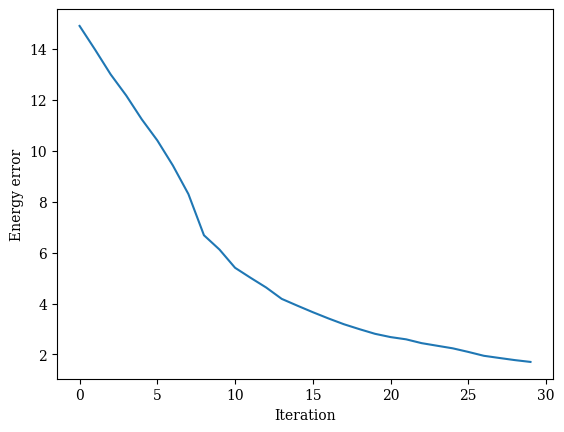

In [25]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [26]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [27]:
noise_model = NoiseModel.from_backend(backend)
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", noise_model=noise_model, matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [28]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

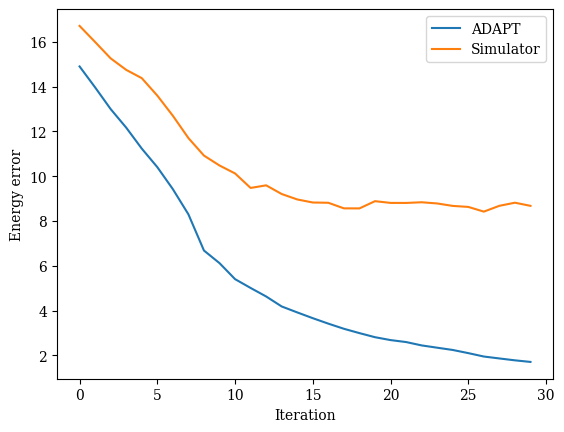

In [29]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [30]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", noise_model=noise_model, matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [31]:
shots_per_circuit = 1_000
num_shots = len(circuits) * shots_per_circuit
sampler = Sampler(sim)

In [32]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'rz': 16, 'sx': 14, 'x': 10, 'cz': 6, 'barrier': 2})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 32, 'sx': 28, 'measure': 20, 'cz': 12, 'x': 11, 'barrier': 3})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 48, 'sx': 42, 'measure': 20, 'cz': 18, 'x': 12, 'barrier': 4})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 64, 'sx': 56, 'cz': 24, 'measure': 20, 'x': 13, 'barrier': 5})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 80, 'sx': 70, 'cz': 30, 'measure': 20, 'x': 14, 'barrier': 6})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 96, 'sx': 84, 'cz': 36, 'measure': 20, 'x': 15, 'barrier': 7})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 112, 'sx': 98, 'cz': 42, 'measure': 20, 'x': 16, 'barrier': 8})
On circuit 7/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 128, 's

In [33]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

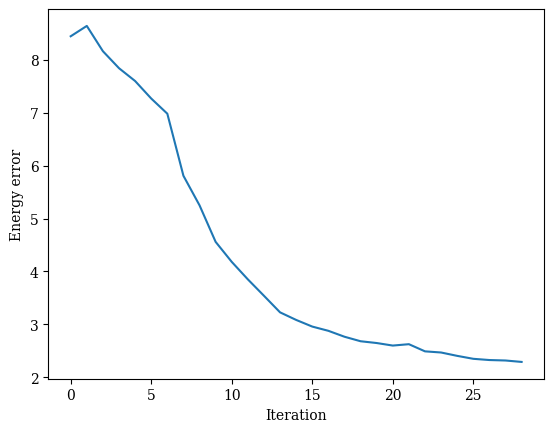

In [34]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [35]:
def randomly_combine_bit_arrays(bit_arrays: List[BitArray], total_shots: int) -> BitArray:
    """Combine several bit arrays by choosing the same number of shots from each of them.
    Choose the shots randomly from each one."""

    shots_per_circuit = [total_shots // len(bit_arrays)] * len(bit_arrays)
    difference = total_shots - sum(shots_per_circuit)
    i = 0
    while i < difference:
        shots_per_circuit[i] += 1
        i += 1
    assert sum(shots_per_circuit) == total_shots

    random_bit_matrices: List[np.ndarray] = []
    num_bits = bit_arrays[0].num_bits
    for i, bit_array in enumerate(bit_arrays):
        assert bit_array.num_shots >= shots_per_circuit[i]
        assert bit_array.num_bits == num_bits
        bit_matrix = bit_array.to_bool_array()
        random_inds = random.sample(list(range(bit_matrix.shape[0])), shots_per_circuit[i])
        random_bit_matrix = bit_matrix[random_inds, :]
        random_bit_matrices.append(random_bit_matrix.copy())
    total_random_bits = np.vstack(random_bit_matrices)
    assert total_random_bits.shape[0] == total_shots
    return BitArray.from_bool_array(total_random_bits)

In [36]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    # all_counts = collections.Counter()
    # tuple_of_counts = tuple(counts_list[:i])
    # assert len(tuple_of_counts) == i
    # for counts in tuple_of_counts:
    #     for bitstring, count in counts.items():
    #         all_counts[bitstring] += count

    # bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_array = randomly_combine_bit_arrays(bit_arrays[:i], num_shots)

    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

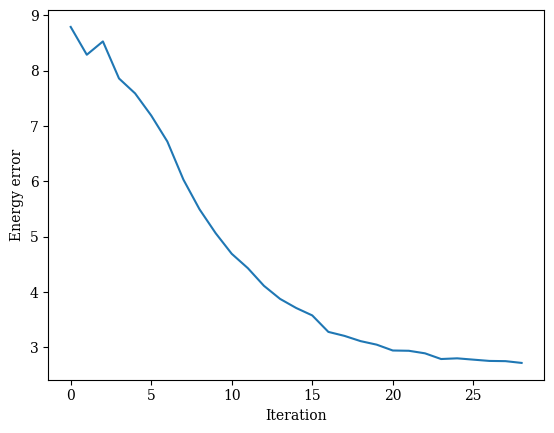

In [37]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

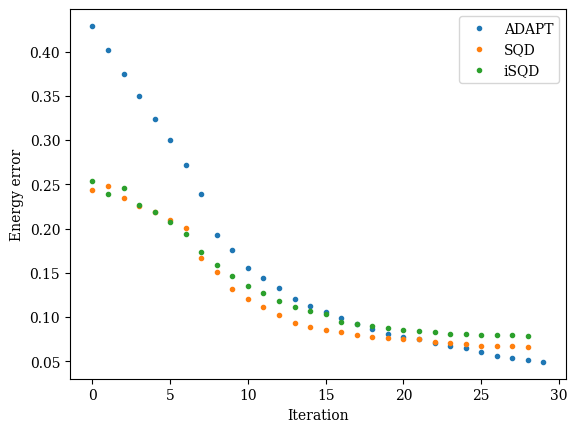

In [38]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [39]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

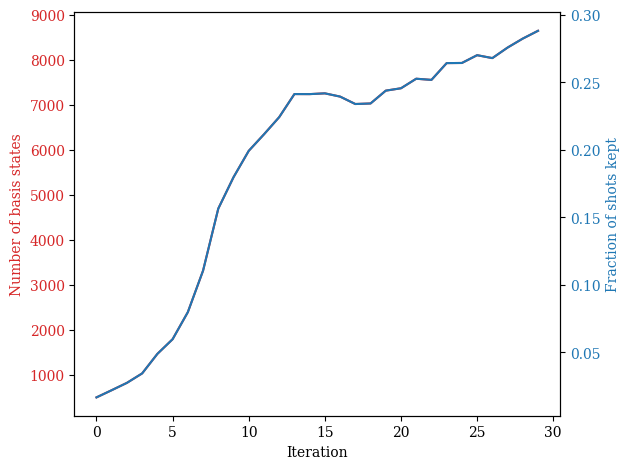

In [40]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

In [41]:
qasm_strs = []
for circuit in circuits:
    # print(circuit.num_qubits)
    # isa_circuit = pass_manager.run(circuit)
    # print(isa_circuit.num_qubits)
    isa_circuit = circuit
    qasm_str = dumps(isa_circuit)
    qasm_strs.append(qasm_str)

In [42]:
f = h5py.File("data/xxz_output.hdf5", "w")
f.create_dataset("qasm_strs", data=qasm_strs)
f.create_dataset("exact_energy", data=exact_energy)
f.create_dataset("adapt_errors", data=np.array(adapt_errors))
f.create_dataset("sqd_errors", data=np.array(errors))
f.create_dataset("isqd_errors", data=np.array(stacked_errors))
f.close()